In [369]:
import requests
from pymongo import MongoClient
from pymongo import GEOSPHERE
import pandas as pd
import json
import geopandas as gpd
import time
import os
import folium
import getpass
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import numpy as np


In [22]:
client = MongoClient("localhost:27017")
db = client["Ironhack"]
c = db.get_collection("companies")


In [89]:
def foursquare_places (venue, coordinates):
    import requests

    url = f"https://api.foursquare.com/v3/places/search?query={venue}&ll={coordinates}&limit=3"

    headers = {
    "accept": "application/json",
    "Authorization": token
}

    response = requests.get(url, headers=headers)
    return response.json()

# Finding out which cities I will be evaluating from. using the amount of other gaming firms in proximity.

In [33]:
gaming_companies = {"category_code": "games_video"}
projection = {"name": 1, "category_code": 1, "_id": 0, "city":1}

results = list(c.find(gaming_companies, projection).sort("gaming_companies", -1).limit(10))
results

[{'name': 'Kyte', 'category_code': 'games_video'},
 {'name': 'blogTV', 'category_code': 'games_video'},
 {'name': 'Joost', 'category_code': 'games_video'},
 {'name': 'Veoh', 'category_code': 'games_video'},
 {'name': 'Stickam', 'category_code': 'games_video'},
 {'name': 'Sparter', 'category_code': 'games_video'},
 {'name': 'Flektor', 'category_code': 'games_video'},
 {'name': 'Lala', 'category_code': 'games_video'},
 {'name': 'Babelgum', 'category_code': 'games_video'},
 {'name': 'YouTube', 'category_code': 'games_video'}]

In [46]:
video_game_category = {"category_code": "games_video"}
raised_amount = {"funding_rounds.raised_amount":{"$gte": 1000000}}
gaming_companies_with_1mil = {"$and": [raised_amount,video_game_category]}

projection = {"name": 1, "category_code": 1, "offices.city": 1, "funding_rounds.raised_amount":1, "_id": 0}

results = list(c.find(gaming_companies_with_1mil, projection).sort("gaming_companies_with_1mil", -1))


pipeline = [
    {"$match": gaming_companies_with_1mil},
    {"$unwind": "$offices"},  
    {"$match": {"offices.city": {"$ne": ""}}},  # excluding the ones that are empty in the city name
    {"$group": {"_id": "$offices.city", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}  
]

top_10_cities_with_gaming_video = list(db["companies"].aggregate(pipeline))

print("Top 10 cities with the most gaming_video that have raised over 1 million$ companies:")
count = 0  
for city_info in top_10_cities_with_gaming_video:
    city = city_info["_id"]
    if city:  # Check if the city name is not empty
        count += 1
        print(f"{city}: {city_info['count']} companies")
    if count == 10:  
        break

Top 10 cities with the most gaming_video that have raised over 1 million$ companies:
San Francisco: 39 companies
New York: 30 companies
Los Angeles: 11 companies
Paris: 9 companies
London: 8 companies
Santa Monica: 8 companies
Palo Alto: 6 companies
Mountain View: 6 companies
San Mateo: 6 companies
Seattle: 6 companies


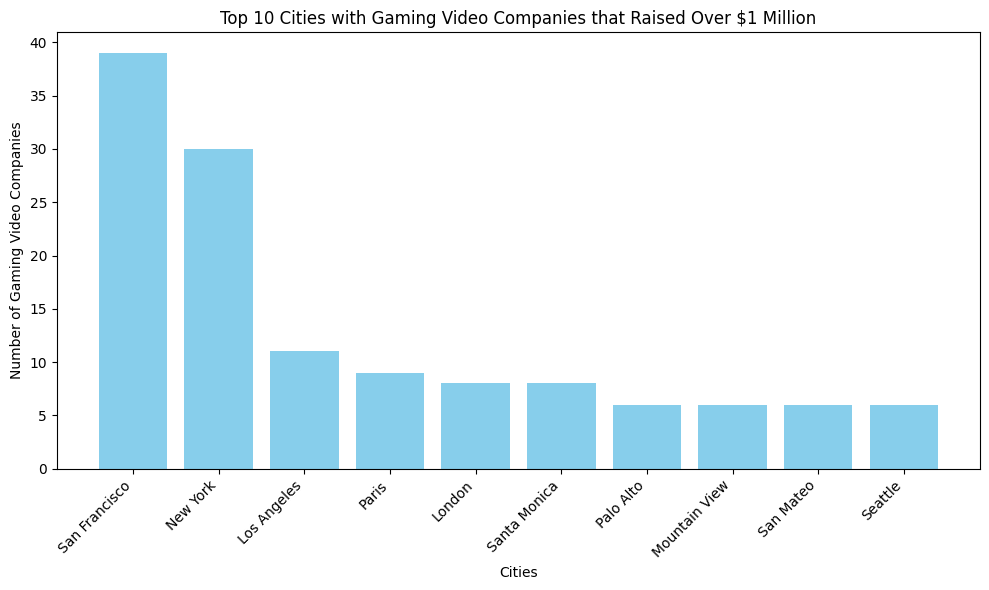

In [47]:
cities = []
counts = []

for city_info in top_10_cities_with_gaming_video:
    cities.append(city_info["_id"])
    counts.append(city_info["count"])

plt.figure(figsize=(10, 6))
plt.bar(cities, counts, color='skyblue')
plt.xlabel('Cities')
plt.ylabel('Number of Gaming Video Companies')
plt.title('Top 10 Cities with Gaming Video Companies that Raised Over $1 Million')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Thus I will be evaluating the three Cities: San Francisco, New york and Los Angeles as the gaming market isnt 
# a local market however we will be able to work together with the other firms in the city and therefore
# will be able to share knowledge and gain knowledge from them and as we are selling to firms all over the world
# the location where the offices is doesnt affect the amount of sales. 

In [ ]:
# lon and lat used for each city: 
# San Franciso: 37.7749, 122.4194 
# Los Angeles: 34.0549, 118.2426
# New York: 40.7128, 74.0060

# Criteria for chosen place: 
# most affordable restaurants, Entertainment Venues, 
# the city that ranks the highest on average in all these categories will be the city the office will be 
# located in

# Restaurants

In [51]:
token = getpass.getpass("Enter your token: ")

Enter your token: ········


In [370]:
# San francisco

import requests

url = "https://api.foursquare.com/v3/places/search?query=Restaurant&near=san%20francisco%2Cca&sort=RATING&limit=50"

headers = {
    "accept": "application/json",
    "Authorization": "fsq3LuiGlLPtsbO78uf7Y8RU8EdZrmZHhfC1BWhVLF5BESo="
}

response = requests.get(url, headers=headers)

print(response.text)


{"results":[{"fsq_id":"5272781811d2ce55eb5981df","categories":[{"id":13002,"name":"Bakery","short_name":"Bakery","plural_name":"Bakeries","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/bakery_","suffix":".png"}},{"id":13035,"name":"Coffee Shop","short_name":"Coffee Shop","plural_name":"Coffee Shops","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_","suffix":".png"}},{"id":13065,"name":"Restaurant","short_name":"Restaurant","plural_name":"Restaurants","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/default_","suffix":".png"}}],"chains":[],"closed_bucket":"Unsure","distance":3217,"geocodes":{"main":{"latitude":37.759602,"longitude":-122.388207},"roof":{"latitude":37.759602,"longitude":-122.388207}},"link":"/v3/places/5272781811d2ce55eb5981df","location":{"address":"2343 3rd St","census_block":"060750226001000","country":"US","cross_street":"at 20th St","dma":"San Francisco-Oakland-San Jose","formatted_address":"2343 3rd St (at 20th St

In [82]:
# LA

import requests

url = "https://api.foursquare.com/v3/places/search?query=Restaurant&near=los%20angeles%2Cca&sort=RATING&limit=50"

headers = {
    "accept": "application/json",
    "Authorization": "fsq3LuiGlLPtsbO78uf7Y8RU8EdZrmZHhfC1BWhVLF5BESo="
}

response = requests.get(url, headers=headers)

print(response.text)

{"results":[{"fsq_id":"55e492b0498ed112bead0545","categories":[{"id":13035,"name":"Coffee Shop","short_name":"Coffee Shop","plural_name":"Coffee Shops","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_","suffix":".png"}},{"id":13068,"name":"American Restaurant","short_name":"American","plural_name":"American Restaurants","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/default_","suffix":".png"}},{"id":13334,"name":"Sandwich Spot","short_name":"Sandwich Spot","plural_name":"Sandwich Spots","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/deli_","suffix":".png"}}],"chains":[],"closed_bucket":"Unsure","distance":5621,"geocodes":{"drop_off":{"latitude":34.10296,"longitude":-118.243561},"main":{"latitude":34.102775,"longitude":-118.243435},"roof":{"latitude":34.102775,"longitude":-118.243435}},"link":"/v3/places/55e492b0498ed112bead0545","location":{"address":"2902 Knox Ave","address_extended":"Unit 100","census_block":"060371872001001","co

In [80]:
# New york

import requests

url = "https://api.foursquare.com/v3/places/search?query=Restaurant&near=new%20york%2Cny&sort=RATING&limit=50"

headers = {
    "accept": "application/json",
    "Authorization": "fsq3LuiGlLPtsbO78uf7Y8RU8EdZrmZHhfC1BWhVLF5BESo="
}

response = requests.get(url, headers=headers)

print(response.text)

{"results":[{"fsq_id":"56e86a57cd1017cb53f3e8f9","categories":[{"id":13236,"name":"Italian Restaurant","short_name":"Italian","plural_name":"Italian Restaurants","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/italian_","suffix":".png"}},{"id":13064,"name":"Pizzeria","short_name":"Pizza","plural_name":"Pizzerias","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/food/pizza_","suffix":".png"}}],"chains":[],"closed_bucket":"Unsure","distance":8001,"geocodes":{"drop_off":{"latitude":40.805427,"longitude":-73.947309},"main":{"latitude":40.805571,"longitude":-73.947505},"roof":{"latitude":40.805571,"longitude":-73.947505}},"link":"/v3/places/56e86a57cd1017cb53f3e8f9","location":{"address":"227 Malcolm X Blvd","census_block":"360610220001000","country":"US","cross_street":"","dma":"New York","formatted_address":"227 Malcolm X Blvd, New York, NY 10027","locality":"New York","postcode":"10027","region":"NY"},"name":"Sottocasa Pizzeria","related_places":{},"timezone":"Ameri

In [83]:
cities = {
    "San Francisco": "https://api.foursquare.com/v3/places/search?query=Restaurant&near=San%20Francisco%2CCA&sort=RATING&limit=50",
    "Los Angeles": "https://api.foursquare.com/v3/places/search?query=Restaurant&near=Los%20Angeles%2CCA&sort=RATING&limit=50",
    "New York": "https://api.foursquare.com/v3/places/search?query=Restaurant&near=New%20York%2CNY&sort=RATING&limit=50"
}

headers = {
    "accept": "application/json",
    "Authorization": "fsq3LuiGlLPtsbO78uf7Y8RU8EdZrmZHhfC1BWhVLF5BESo="
}

def get_average_rating(city_url):
    response = requests.get(city_url, headers=headers)
    data = response.json()
    restaurants = data.get("places", [])
    total_rating = sum(restaurant.get("rating", 0) for restaurant in restaurants)
    average_rating = total_rating / len(restaurants) if restaurants else 0
    return average_rating

# Calculate average ratings for each city
average_ratings = {}
for city, url in cities.items():
    average_ratings[city] = get_average_rating(url)

# Print average ratings for each city
for city, rating in average_ratings.items():
    print(f"Average rating in {city}: {rating:.2f}")

Average rating in San Francisco: 0.00
Average rating in Los Angeles: 0.00
Average rating in New York: 0.00


# Entertainment Venues

In [ ]:
# new york

import requests

url = "https://api.foursquare.com/v3/places/search?query=Entertainment&near=new%20york%2Cny"

headers = {
    "accept": "application/json",
    "Authorization": "fsq3LuiGlLPtsbO78uf7Y8RU8EdZrmZHhfC1BWhVLF5BESo="
}

response = requests.get(url, headers=headers)

print(response.text)

In [84]:
# Los angeles

import requests

url = "https://api.foursquare.com/v3/places/search?query=Entertainment&near=Los%20angeles%2CCA"

headers = {
    "accept": "application/json",
    "Authorization": "fsq3LuiGlLPtsbO78uf7Y8RU8EdZrmZHhfC1BWhVLF5BESo="
}

response = requests.get(url, headers=headers)

print(response.text)

{"results":[{"fsq_id":"4bfd7a58f7c82d7f363f8e04","categories":[{"id":11035,"name":"Entertainment Agency","short_name":"Entertainment Agency","plural_name":"Entertainment Agencies","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/building/default_","suffix":".png"}}],"chains":[],"closed_bucket":"VeryLikelyClosed","distance":1015,"geocodes":{"drop_off":{"latitude":34.043543,"longitude":-118.241551},"main":{"latitude":34.043296,"longitude":-118.241278},"roof":{"latitude":34.043296,"longitude":-118.241278}},"link":"/v3/places/4bfd7a58f7c82d7f363f8e04","location":{"address":"440 Towne Ave","census_block":"060372062021014","country":"US","dma":"Los Angeles","formatted_address":"440 Towne Ave, Los Angeles, CA 90013","locality":"Los Angeles","postcode":"90013","region":"CA"},"name":"Deuce Entertainment","related_places":{},"timezone":"America/Los_Angeles"},{"fsq_id":"4f32d02519836c91c7fd7dd3","categories":[{"id":13003,"name":"Bar","short_name":"Bar","plural_name":"Bars","icon":{"prefix

In [88]:
import requests

url = "https://api.foursquare.com/v3/places/search?query=Entertainment%20&near=New%20York%2CNY"

headers = {
    "accept": "application/json",
    "Authorization": "fsq3LuiGlLPtsbO78uf7Y8RU8EdZrmZHhfC1BWhVLF5BESo="
}

response = requests.get(url, headers=headers)

print(response.text)

{"results":[{"fsq_id":"4cc19a5e967d54813fbc7857","categories":[{"id":11000,"name":"Business and Professional Services","short_name":"Business and Professional Services","plural_name":"Business and Professional Services","icon":{"prefix":"https://ss3.4sqi.net/img/categories_v2/building/default_","suffix":".png"}}],"chains":[],"closed_bucket":"LikelyClosed","distance":227,"geocodes":{"main":{"latitude":40.743677,"longitude":-73.991291},"roof":{"latitude":40.743677,"longitude":-73.991291}},"link":"/v3/places/4cc19a5e967d54813fbc7857","location":{"address":"48 W 25th St","census_block":"360610058002002","country":"US","cross_street":"","dma":"New York","formatted_address":"48 W 25th St, New York, NY 10010","locality":"New York","postcode":"10010","region":"NY"},"name":"Vrtcl Entertainment","related_places":{},"timezone":"America/New_York"},{"fsq_id":"4f324d6c19836c91c7ca58e0","categories":[{"id":13065,"name":"Restaurant","short_name":"Restaurant","plural_name":"Restaurants","icon":{"prefix

# Trying out the function the foursquare_places function on the different cities: 

In [348]:
# Los angeles

foursquare_places ("Restaurant", "34.0549,118.2426")
pass

In [347]:
# New York: 40.7128, -74.0060


foursquare_places ("Restaurant", "40.730610,-73.935242")
pass

In [109]:
# San Franciso: 37.7749, 122.4194 
foursquare_places ("Restaurant", "37.7749,-122.4194")

{'results': [{'fsq_id': '5e82886cc3e6830008549196',
   'categories': [{'id': 13106,
     'name': 'Dim Sum Restaurant',
     'short_name': 'Dim Sum',
     'plural_name': 'Dim Sum Restaurants',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dimsum_',
      'suffix': '.png'}},
    {'id': 13137,
     'name': 'Dumpling Restaurant',
     'short_name': 'Dumplings',
     'plural_name': 'Dumpling Restaurants',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dumplings_',
      'suffix': '.png'}}],
   'chains': [],
   'closed_bucket': 'LikelyOpen',
   'distance': 338,
   'geocodes': {'drop_off': {'latitude': 37.775799, 'longitude': -122.422776},
    'main': {'latitude': 37.775828, 'longitude': -122.422637},
    'roof': {'latitude': 37.775828, 'longitude': -122.422637}},
   'link': '/v3/places/5e82886cc3e6830008549196',
   'location': {'address': '298 Gough St',
    'census_block': '060750162002005',
    'country': 'US',
    'cross_street': '',
    'dma':

# the office will be going to san francisco 

In [250]:
def find_things (venue, lat, lon, sort, limit):

    url = f"https://api.foursquare.com/v3/places/search?query={venue}&ll={lat}%2C{lon}&sort=DISTANCE&limit=5"

    headers = {
        "accept": "application/json",
        "Authorization": token
    }

    response = requests.get(url, headers=headers).json()

    return response

response_SF = find_things("restaurants","37.7749", "-122.4194", "rating", "50")
response_SF

{'results': [{'fsq_id': '5e82886cc3e6830008549196',
   'categories': [{'id': 13106,
     'name': 'Dim Sum Restaurant',
     'short_name': 'Dim Sum',
     'plural_name': 'Dim Sum Restaurants',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dimsum_',
      'suffix': '.png'}},
    {'id': 13137,
     'name': 'Dumpling Restaurant',
     'short_name': 'Dumplings',
     'plural_name': 'Dumpling Restaurants',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dumplings_',
      'suffix': '.png'}}],
   'chains': [],
   'closed_bucket': 'LikelyOpen',
   'distance': 338,
   'geocodes': {'drop_off': {'latitude': 37.775799, 'longitude': -122.422776},
    'main': {'latitude': 37.775828, 'longitude': -122.422637},
    'roof': {'latitude': 37.775828, 'longitude': -122.422637}},
   'link': '/v3/places/5e82886cc3e6830008549196',
   'location': {'address': '298 Gough St',
    'census_block': '060750162002005',
    'country': 'US',
    'cross_street': '',
    'dma':

In [141]:
token = "fsq3vNo5414KvBYPwVb75HsQgKuTAh9qmwq/qYrKBdblnOs="
def find_things(venue, lat, lon, token):
    url = f"https://api.foursquare.com/v3/places/search?intent=browse&ll={lat},{lon}&categoryId={venue}&limit=5"
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {token}"
    }
    response = requests.get(url, headers=headers).json()
    return response

# Example usage
response = find_things("4d4b7105d754a06374d81259", "37.7749", "-122.4194", "token")  # Example category ID for restaurants
print(response)

{'message': 'Invalid request token.'}


In [139]:
response_SF

{'results': [{'fsq_id': '5e82886cc3e6830008549196',
   'categories': [{'id': 13106,
     'name': 'Dim Sum Restaurant',
     'short_name': 'Dim Sum',
     'plural_name': 'Dim Sum Restaurants',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dimsum_',
      'suffix': '.png'}},
    {'id': 13137,
     'name': 'Dumpling Restaurant',
     'short_name': 'Dumplings',
     'plural_name': 'Dumpling Restaurants',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dumplings_',
      'suffix': '.png'}}],
   'chains': [],
   'closed_bucket': 'LikelyOpen',
   'distance': 338,
   'geocodes': {'drop_off': {'latitude': 37.775799, 'longitude': -122.422776},
    'main': {'latitude': 37.775828, 'longitude': -122.422637},
    'roof': {'latitude': 37.775828, 'longitude': -122.422637}},
   'link': '/v3/places/5e82886cc3e6830008549196',
   'location': {'address': '298 Gough St',
    'census_block': '060750162002005',
    'country': 'US',
    'cross_street': '',
    'dma':

In [ ]:
# import requests

url = "https://api.foursquare.com/v3/places/search"

headers = {
    "accept": "application/json",
    "Authorization": "fsq3LuiGlLPtsbO78uf7Y8RU8EdZrmZHhfC1BWhVLF5BESo="
}

response = requests.get(url, headers=headers)

print(response.text)

In [143]:
san_francisco_loc = [37.75404,-122.44721]

# finding the best location

In [160]:
import folium
import requests

# Foursquare API access token
ACCESS_TOKEN = 'YOUR_FOURSQUARE_ACCESS_TOKEN'
VERSION = '20220212'

# San Francisco coordinates
sf_lat, sf_lng = 37.7749, -122.4194

# Function to search for venues
def search_venues(category_name, lat, lon, radius=1000, limit=50):
    url = f"https://api.foursquare.com/v2/venues/explore"
    params = {
        'oauth_token': ACCESS_TOKEN,
        'v': VERSION,
        'll': f'{lat},{lon}',
        'radius': radius,
        'limit': limit,
        'query': category_name  # Use query parameter instead of categoryId
    }
    response = requests.get(url, params=params).json()
    if response['meta']['code'] == 200:
        return response['response']['groups'][0]['items']
    else:
        return None

# Define categories and corresponding icons
categories = {
    'restaurant': {'query': 'restaurant', 'icon': 'cutlery'},
    'public_transport': {'query': 'public transport', 'icon': 'train'},
    'starbucks': {'query': 'starbucks', 'icon': 'coffee'}
}

# Create a map centered at San Francisco coordinates
mymap = folium.Map(location=[sf_lat, sf_lng], zoom_start=13)

# Plot markers for each venue category
for category, data in categories.items():
    venues = search_venues(data['query'], sf_lat, sf_lng)
    if venues is not None:
        for venue in venues:
            lat = venue['venue']['location']['lat']
            lon = venue['venue']['location']['lng']
            folium.Marker([lat, lon], popup=venue['venue']['name'], icon=folium.Icon(icon=data['icon'])).add_to(mymap)

# Save the map as an HTML file
mymap.save("office_location_map.html")

In [203]:
ACCESS_TOKEN = "fsq3gd+WN5RguHeeVNROZ1WXQISUPmJitWhXfUzzvNxGCHA="
def search_venues(category_name, lat, lon, radius=1000, limit=50):
    url = f"https://api.foursquare.com/v2/venues/explore"
    params = {
        'oauth_token': ACCESS_TOKEN,
        'll': f'{lat},{lon}',
        'radius': radius,
        'limit': limit,
        'query': category_name  # Use query parameter instead of categoryId
    }
    response = requests.get(url, params=params).json()
    return response
    
search_venues("starbucks", -127, 30)


import requests

url = "https://api.foursquare.com/v3/places/search"

headers = {
    "accept": "application/json",
    "Authorization": ACCESS_TOKEN
}

response = requests.get(url, headers=headers)

response.json()

{'results': [{'fsq_id': '5c4714533ba767002caedd2b',
   'categories': [{'id': 13302,
     'name': 'Mediterranean Restaurant',
     'short_name': 'Mediterranean',
     'plural_name': 'Mediterranean Restaurants',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mediterranean_',
      'suffix': '.png'}}],
   'chains': [],
   'closed_bucket': 'VeryLikelyOpen',
   'distance': 179,
   'geocodes': {'drop_off': {'latitude': 41.387677, 'longitude': 2.168101},
    'main': {'latitude': 41.387526, 'longitude': 2.167989},
    'roof': {'latitude': 41.387526, 'longitude': 2.167989}},
   'link': '/v3/places/5c4714533ba767002caedd2b',
   'location': {'address': 'Rambla Catalunya, 3',
    'admin_region': 'Cataluña',
    'country': 'ES',
    'cross_street': '',
    'formatted_address': 'Rambla Catalunya, 3, 08007 Barcelona Catalunya',
    'locality': 'Barcelona',
    'postcode': '08007',
    'region': 'Catalunya'},
   'name': 'Honest Greens Rambla Catalunya',
   'related_places': {},
 

In [254]:
def find_things (venue, lat, lon, sort, limit):

    url = f"https://api.foursquare.com/v3/places/search?query={venue}&ll={lat}%2C{lon}&sort=DISTANCE&limit=50"

    headers = {
        "accept": "application/json",
        "Authorization": token
    }

    response = requests.get(url, headers=headers).json()

    return response

response_SF = find_things("restaurants","37.7749", "-122.4194", "rating", "50")
response_SF

def process_response_into_df (response):
    new_list = []
    for venue in response["results"]:
        name = venue["name"]
        lat = venue["geocodes"]["main"]["latitude"]
        lon = venue["geocodes"]["main"]["longitude"]
        dict_ = {
            "name": name,
            "lat": lat,
            "lon": lon
        }
        new_list.append(dict_)
    return pd.DataFrame(new_list)


def insert_df_into_mongo (df, collection):
    client = pymongo.MongoClient("localhost:27017")
    db = client["ironhack"]
    c = db.get_collection(collection)
    for index, row in df.iterrows():
        c.insert_one(dict(row))

In [357]:
process_response_into_df(response_SF)

,name,lat,lon
0,Dumpling Home,37.775828,-122.422637
1,Gioia Pizzeria,37.776341,-122.425749
2,Burma Love,37.769594,-122.422125
3,The Cake Gallery,37.773800,-122.411980
4,Shizen,37.768028,-122.421674
5,Rintaro,37.768854,-122.415129
6,Arsicault,37.780748,-122.413394
7,Square Pie Guys,37.779530,-122.410096
8,Beit Rima,37.768620,-122.429306
9,Deli Board,37.777639,-122.407046


In [358]:
response_SF = find_things("restaurants","37.7749", "-122.4194", "rating", "50")
df = process_response_into_df(response_SF)
for _, row in df.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=folium.Icon(icon='cutlery')).add_to(sf_map)

response_Starbucks = find_things("Starbucks","37.7749", "-122.4194", "rating", "50")
response_Starbucks
df_starbucks = process_response_into_df(response_Starbucks)


# Create a Folium map centered around San Francisco
sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=13)

# Function to determine icon based on venue name


# Add markers for each venue to the map
for _, row in df.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=folium.Icon(icon='cutlery')).add_to(sf_map)
    
for _, row in df_starbucks.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=folium.Icon(color="darkpurple",icon="coffee", prefix='fa')).add_to(sf_map)

# Display the map
sf_map

In [309]:
#df_starbucks

In [359]:
df = process_response_into_df(response_SF)
response_Starbucks = find_things("Starbucks","37.7749", "-122.4194", "rating", "50")
response_Starbucks
df_starbucks = process_response_into_df(response_Starbucks)


# Create a Folium map centered around San Francisco
sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=13)

# Function to determine icon based on venue name


# Add markers for each venue to the map
for _, row in df.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=folium.Icon(icon='cutlery')).add_to(sf_map)

In [364]:
for _, row in df_starbucks.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=folium.Icon(color="darkpurple",icon="coffee", prefix='fa')).add_to(sf_map)

In [360]:
response_Metro = find_things("Train Station","37.7749", "-122.4194", "rating", "50")
df_metro = process_response_into_df(response_Metro)


for _, row in df_metro.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=folium.Icon(color="gray",icon="train", prefix='fa')).add_to(sf_map)
    

In [361]:
sf_map

In [362]:
response_bar = find_things("bar","37.7749", "-122.4194", "rating", "50")
df_bar = process_response_into_df(response_bar)


for _, row in df_bar.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=folium.Icon(color="pink",icon="beer", prefix='fa')).add_to(sf_map)
sf_map

In [363]:
response_airport = find_things("San Francisco International Airport","37.7749", "-122.4194", "rating", "50")
df_airport = process_response_into_df(response_airport)


for _, row in df_airport.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=folium.Icon(color="green",icon="plane", prefix='fa')).add_to(sf_map)
sf_map

# Creating Layer

In [ ]:
starbucks_layer = folium.FeatureGroup(name='Starbucks')
for _, row in df_starbucks.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name']).add_to(starbucks_layer)
starbucks_layer.add_to(sf_map)

# Create a layer for restaurant markers
restaurants_layer = folium.FeatureGroup(name='Restaurants')
for _, row in df.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name']).add_to(restaurants_layer)
restaurants_layer.add_to(sf_map)

bar_layer = folium.FeatureGroup(name='Bar')
for _, row in df_bar.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name']).add_to(bar_layer)
bar_layer.add_to(sf_map)

airport_layer = folium.FeatureGroup(name='Airport')
for _, row in df_airport.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name']).add_to(airport_layer)
airport_layer.add_to(sf_map)

metro_layer = folium.FeatureGroup(name='metro')
for _, row in df_metro.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name']).add_to(metro_layer)
metro_layer.add_to(sf_map)

folium.LayerControl().add_to(sf_map)

# Display the map
sf_map

# Plotting a heat map

In [367]:
all_df = pd.concat([df_starbucks, df, df_airport, df_bar, df_metro], ignore_index=True)


combined_heat_data = []
for df in [all_df]:
    combined_heat_data.extend([[row['lat'], row['lon']] for _, row in df.iterrows()])

# Create a Folium map centered around San Francisco
sf_map_heat = folium.Map(location=[37.7749, -122.4194], zoom_start=13)

# Create a HeatMap layer using the combined latitude and longitude data
HeatMap(combined_heat_data).add_to(sf_map_heat)

sf_map_heat